# Plant Leaf Disease Classifier

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
#import os
#os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2
from keras.optimizers import SGD, RMSprop

In [5]:
import os
import pandas as pd
import numpy as np


from keras.preprocessing.image import ImageDataGenerator

In [6]:
root = 'leaf_classif'
print(os.path.join(root, 'train'))

leaf_classif\train


# First CNN Model

**We extracted the pictures of leaves and gave them their corresponding labels**

**All of the leaf pictures have the dimensions 6000 x 4000 and 96 dpi for both horizontal and vertical resolution**

In [7]:
import random

main_dir = root  # Replace with your main directory

def label_from_folder_name(folder_name):
    if 'healthy' in folder_name:
        return 'healthy'  # Class label for healthy images
    elif 'diseased' in folder_name:
        return 'diseased'  # Class label for unhealthy images
    else:
        return None  # No specific label found
    
def custom_flow_from_directory(directory, target_size, batch_size):
    filenames = []
    labels = []

    for folder in os.listdir(directory):
        # first 2 folders
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for root, dirs, files in os.walk(folder_path):
                 for file in files:
                     filenames.append(os.path.join(root, file))
                     labels.append(label_from_folder_name(root))

    filenames = np.array(filenames)
    labels = np.array(labels, dtype=str)  # Ensure labels are strings

    return ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        pd.DataFrame({"filename": filenames, "class": labels}),
        x_col="filename",
        y_col="class",
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

# Use the custom function to load data
batch_size = 32
img_height, img_width = 150, 150

train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'test')
valid_dir = os.path.join(main_dir, 'valid')

train_generator = custom_flow_from_directory(train_dir, (img_height, img_width), batch_size)
test_generator = custom_flow_from_directory(test_dir, (img_height, img_width), batch_size)
valid_generator = custom_flow_from_directory(valid_dir, (img_height, img_width), batch_size)


Found 4274 validated image filenames belonging to 2 classes.
Found 110 validated image filenames belonging to 2 classes.
Found 110 validated image filenames belonging to 2 classes.


In [5]:
# Build a CNN model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Adding dropout
    Dense(1, activation='sigmoid')
])

# Compile the model with a different optimizer and learning rate
from tensorflow.keras.optimizers import Adam

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

**We used a Convolutional Neural Network (CNN) from the Keras library to build a sequential model.**

**Convolutional layers**
- The first convolutional layer (Conv2D) has 32 filters, each with a 3x3 kernel. It applies the Rectified Linear Unit (ReLU) activation function.
- The second convolutional layer has 64 filters with a 3x3 kernel and ReLU activation.
- The third convolutional layer has 128 filters with a 3x3 kernel and ReLU activation.
- After each convolutional layer, a max-pooling layer (MaxPooling2D) with a 2x2 pool size is applied. This reduces the spatial dimensions of the representation and captures the most important information.

**Dense layers**
- The first fully connected layer (Dense) has 128 neurons with ReLU activation. It processes the flattened features from the previous layer.
- The second and final fully connected layer has 1 neuron with a sigmoid activation function. This neuron outputs the probability of belonging to the positive class in binary classification tasks.

**Model Compilation**
- The model is compiled using the Adam optimizer ('adam'), a popular optimization algorithm.
- The loss function used for training is binary crossentropy ('binary_crossentropy'), suitable for binary classification problems.
- The metric to monitor during training is accuracy ('accuracy').

In [6]:
# Calculate steps_per_epoch and validation_steps
steps_per_epoch_train = train_generator.samples // batch_size
steps_per_epoch_valid = valid_generator.samples // batch_size
steps_per_epoch_test = test_generator.samples // batch_size

epochs = 10
# Add 1 extra step if there are remaining samples not included in batches
if train_generator.samples % batch_size != 0:
    steps_per_epoch_train += 1
if valid_generator.samples % batch_size != 0:
    steps_per_epoch_valid += 1
if test_generator.samples % batch_size != 0:
    steps_per_epoch_test += 1

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=steps_per_epoch_valid,
    callbacks=[early_stopping]
)

Epoch 1/10
134/134 [==============================] - 2165s 16s/step - loss: 0.6729 - accuracy: 0.5681 - val_loss: 0.5995 - val_accuracy: 0.6182
Epoch 2/10
134/134 [==============================] - 1996s 15s/step - loss: 0.5505 - accuracy: 0.7213 - val_loss: 0.6426 - val_accuracy: 0.6727
Epoch 3/10
134/134 [==============================] - 1190s 9s/step - loss: 0.3728 - accuracy: 0.8376 - val_loss: 0.4676 - val_accuracy: 0.7818
Epoch 4/10
134/134 [==============================] - 834s 6s/step - loss: 0.2823 - accuracy: 0.8854 - val_loss: 0.3723 - val_accuracy: 0.8455
Epoch 5/10
134/134 [==============================] - 836s 6s/step - loss: 0.2079 - accuracy: 0.9197 - val_loss: 0.3362 - val_accuracy: 0.8727
Epoch 6/10
134/134 [==============================] - 1116s 8s/step - loss: 0.1741 - accuracy: 0.9307 - val_loss: 0.3838 - val_accuracy: 0.8455
Epoch 7/10
134/134 [==============================] - 6951s 52s/step - loss: 0.1519 - accuracy: 0.9429 - val_loss: 0.4093 - val_accuracy

In [7]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=steps_per_epoch_test)

4/4 [==============================] - 49s 12s/step - loss: 0.3633 - accuracy: 0.8727


# Fine-tuned CNN model
**Doubling number of epochs to 20, reducing steps size by half**

In [8]:
# Calculate steps_per_epoch and validation_steps
steps_per_epoch_train = train_generator.samples // (batch_size * 2)
steps_per_epoch_valid = valid_generator.samples // (batch_size * 2)
steps_per_epoch_test = test_generator.samples // (batch_size * 2)

epochs = 20
# Add 1 extra step if there are remaining samples not included in batches
if train_generator.samples % batch_size != 0:
    steps_per_epoch_train += 1
if valid_generator.samples % batch_size != 0:
    steps_per_epoch_valid += 1
if test_generator.samples % batch_size != 0:
    steps_per_epoch_test += 1

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=steps_per_epoch_valid
)

Epoch 1/20
67/67 [==============================] - 2653s 40s/step - loss: 0.0715 - accuracy: 0.9767 - val_loss: 0.5805 - val_accuracy: 0.7969
Epoch 2/20
67/67 [==============================] - 438s 7s/step - loss: 0.0663 - accuracy: 0.9785 - val_loss: 0.3138 - val_accuracy: 0.9062
Epoch 3/20
67/67 [==============================] - 440s 7s/step - loss: 0.0764 - accuracy: 0.9742 - val_loss: 0.3154 - val_accuracy: 0.8750
Epoch 4/20
67/67 [==============================] - 452s 7s/step - loss: 0.0539 - accuracy: 0.9809 - val_loss: 0.4993 - val_accuracy: 0.8281
Epoch 5/20
67/67 [==============================] - 447s 7s/step - loss: 0.0528 - accuracy: 0.9781 - val_loss: 0.7598 - val_accuracy: 0.8281
Epoch 6/20
67/67 [==============================] - 448s 7s/step - loss: 0.0337 - accuracy: 0.9888 - val_loss: 0.5502 - val_accuracy: 0.8281
Epoch 7/20
67/67 [==============================] - 443s 7s/step - loss: 0.0651 - accuracy: 0.9743 - val_loss: 0.5912 - val_accuracy: 0.8438
Epoch 8/20


**This fine-tuned model had better accuracy than the previous model.**

**Perhaps this can be attributed to over-fitting introduced by further tuning.**

In [9]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=steps_per_epoch_test)

2/2 [==============================] - 13s 7s/step - loss: 0.8195 - accuracy: 0.8438


# Pre-trained model -- MobileNet
**Use a model built from a pretrained model**

In [10]:
# Use pretrained model
from keras.applications import MobileNet
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

# Define input image size expected by MobileNet
img_width, img_height = 224, 224

# Load the MobileNet model without the top classification layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification using sigmoid activation

# Combine base model with custom top layers
mobileModel = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
mobileModel.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
# Train the model

# Calculate steps_per_epoch and validation_steps
steps_per_epoch_train = train_generator.samples // batch_size
steps_per_epoch_valid = valid_generator.samples // batch_size
epochs = 10
# Add 1 extra step if there are remaining samples not included in batches
if train_generator.samples % batch_size != 0:
    steps_per_epoch_train += 1
if valid_generator.samples % batch_size != 0:
    steps_per_epoch_valid += 1

mobileModel.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=steps_per_epoch_valid
)

Epoch 1/10
134/134 [==============================] - 876s 7s/step - loss: 0.4070 - accuracy: 0.8121 - val_loss: 0.4166 - val_accuracy: 0.7909
Epoch 2/10
134/134 [==============================] - 861s 6s/step - loss: 0.2638 - accuracy: 0.8896 - val_loss: 0.4393 - val_accuracy: 0.7818
Epoch 3/10
134/134 [==============================] - 863s 6s/step - loss: 0.2264 - accuracy: 0.9038 - val_loss: 0.4214 - val_accuracy: 0.8455
Epoch 4/10
134/134 [==============================] - 871s 7s/step - loss: 0.1871 - accuracy: 0.9242 - val_loss: 0.3671 - val_accuracy: 0.8455
Epoch 5/10
134/134 [==============================] - 860s 6s/step - loss: 0.1815 - accuracy: 0.9331 - val_loss: 0.5241 - val_accuracy: 0.8182
Epoch 6/10
134/134 [==============================] - 1199s 9s/step - loss: 0.1550 - accuracy: 0.9366 - val_loss: 0.4614 - val_accuracy: 0.8364
Epoch 7/10
134/134 [==============================] - 1909s 14s/step - loss: 0.1243 - accuracy: 0.9527 - val_loss: 0.5298 - val_accuracy: 0.8

**The pretrained model actually performed quite well with 89% accuracy**

In [12]:
# Evaluate the model on the test dataset
loss, accuracy = mobileModel.evaluate(test_generator)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

4/4 [==============================] - 20s 5s/step - loss: 0.4332 - accuracy: 0.8727
Test Loss: 0.4332
Test Accuracy: 87.27%


# Fine-tuned pre-trained model

In [11]:

# Calculate steps_per_epoch and validation_steps
steps_per_epoch_train = train_generator.samples // (batch_size * 2)
steps_per_epoch_valid = valid_generator.samples // (batch_size * 2)
epochs = 20
# Add 1 extra step if there are remaining samples not included in batches
history = mobileModel.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=steps_per_epoch_valid
)

Epoch 1/20
66/66 [==============================] - 610s 9s/step - loss: 0.4882 - accuracy: 0.7798 - val_loss: 0.5659 - val_accuracy: 0.6562
Epoch 2/20
66/66 [==============================] - 410s 6s/step - loss: 0.3102 - accuracy: 0.8665 - val_loss: 0.4891 - val_accuracy: 0.7812
Epoch 3/20
66/66 [==============================] - 429s 7s/step - loss: 0.2571 - accuracy: 0.8939 - val_loss: 0.4800 - val_accuracy: 0.7812
Epoch 4/20
66/66 [==============================] - 376s 6s/step - loss: 0.2337 - accuracy: 0.9015 - val_loss: 0.4924 - val_accuracy: 0.8125
Epoch 5/20
66/66 [==============================] - 377s 6s/step - loss: 0.2129 - accuracy: 0.9147 - val_loss: 0.4210 - val_accuracy: 0.7812
Epoch 6/20
66/66 [==============================] - 395s 6s/step - loss: 0.2189 - accuracy: 0.9096 - val_loss: 0.5186 - val_accuracy: 0.7500
Epoch 7/20
66/66 [==============================] - 390s 6s/step - loss: 0.2004 - accuracy: 0.9185 - val_loss: 0.3781 - val_accuracy: 0.8750
Epoch 8/20
66

**Fine-tuning the model did improved it slightly with 90% accuracy**

In [12]:
# Evaluate the model on the test dataset
loss, accuracy = mobileModel.evaluate(test_generator)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

4/4 [==============================] - 23s 5s/step - loss: 0.3438 - accuracy: 0.9182
Test Loss: 0.3438
Test Accuracy: 91.82%


In [13]:
# Evaluate the model on the test dataset
loss, accuracy = mobileModel.evaluate(test_generator)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

4/4 [==============================] - 23s 5s/step - loss: 0.3438 - accuracy: 0.9182
Test Loss: 0.3438
Test Accuracy: 91.82%


# Images to display
**the images below are scale down to the size 224 * 224, which is the size of the images we used for the MobileNet model**

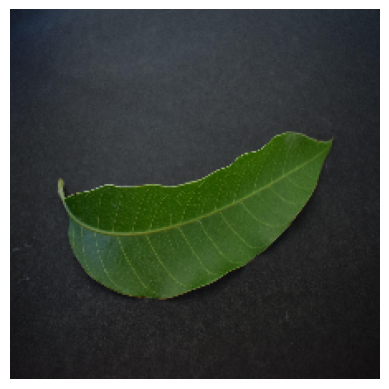

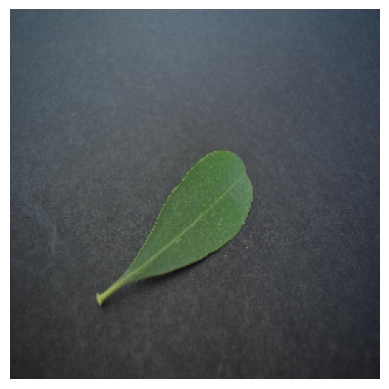

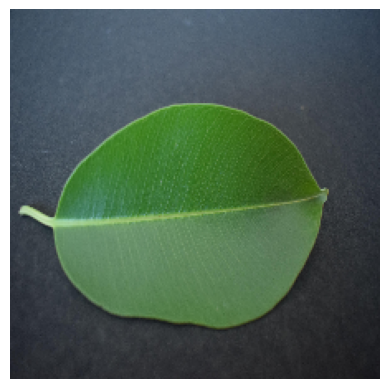

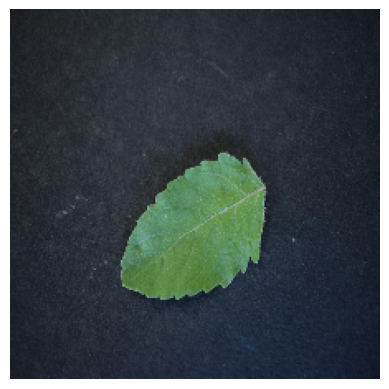

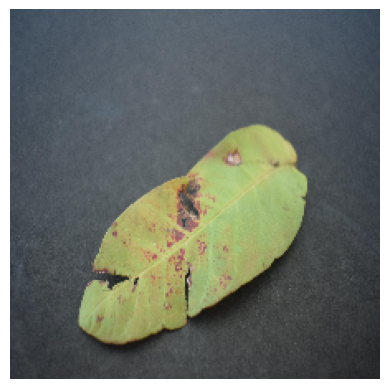

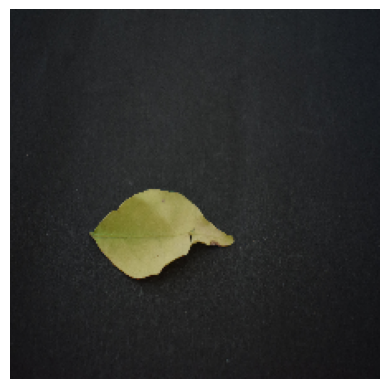

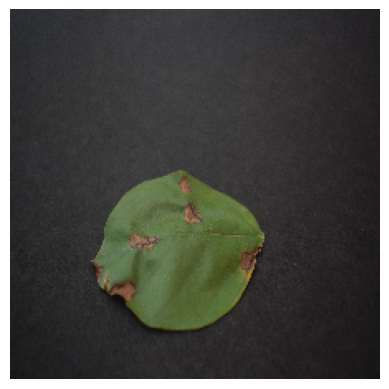

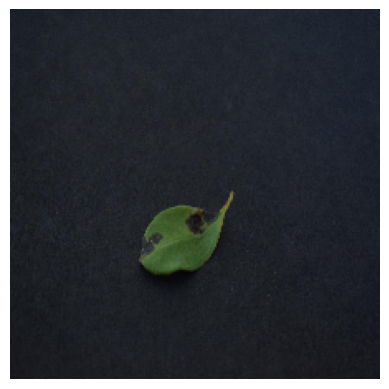

In [15]:
# Get the current working directory
current_dir = os.getcwd()

# Specify the path to the "predict" folder in the same directory as the notebook
folder_path = os.path.join(current_dir, "leaf_classif/predict")

# Make sure to define img_height and img_width before using them
img_height = 224
img_width = 224

# Function to display images from a folder
def display_images_from_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".JPG"):
            img_path = os.path.join(folder_path, filename)
            img = image.load_img(img_path, target_size=(img_height, img_width))
            img_array = image.img_to_array(img)

            # Display the image
            plt.imshow(img_array.astype('uint8'))
            plt.axis('off')
            plt.show()

# Display images from the "predict" folder
display_images_from_folder(folder_path)


# Conclusion
**This best model is overfitting the training dataset. Most of the error in our model can likely be attributed to overfitting the training dataset, as it reaches 100% accuracy in the training sets quickly.**

**Another factor that could be causing non-optimal accuracy is the low image resolution, since the original images were too large and we had to scale them down in the code.**